In [34]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io.arff import loadarff
from scipy.stats import chi2_contingency
from scipy.stats.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

/var/folders/8n/y1nxc5zd3c9_k18s4j2fstsw0000gn/T/ipykernel_9493/2113948404.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr
/var/folders/8n/y1nxc5zd3c9_k18s4j2fstsw0000gn/T/ipykernel_9493/2113948404.py:8: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr, spearmanr


In [35]:
def unify_item(item):
    if isinstance(item, bytes):
        return item.decode()
    return item


def chi_square(x, y):
    df = pd.DataFrame({'X': x, 'Y': y})
    crosstab = pd.crosstab(index=df['X'], columns=df['Y'])
    res = chi2_contingency(crosstab.values)
    return res[0]


def mean_corr(x, y):
    return corr_with(x, y).values.mean()


def min_corr(x, y):
    return corr_with(x, y).values.min()


def max_corr(x, y):
    return corr_with(x, y).values.max()


def corr_with(x, y):
    y_str = list(map(unify_item, y))
    dummies = pd.Series(y_str).str.get_dummies()
    corrwith = dummies.corrwith(pd.Series(x))
    return corrwith


def entropy(Y):
    unique, count = np.unique(Y, return_counts=True)
    prob = count / len(Y)
    en = np.sum((-1) * prob * np.log(prob))
    return en


def cond_entropy(X, Y):
    return entropy(np.c_[Y, X]) - entropy(X)


def merge_dicts(from_dict, to_dict, key_transform=None, value_as_list=True):
    for func in from_dict:
        res_key_name = func if key_transform is None else key_transform(func)
        if value_as_list:
            if res_key_name not in to_dict:
                to_dict[res_key_name] = []
            to_dict[res_key_name].append(from_dict[func])
        else:
            to_dict[res_key_name] = from_dict[func]


def vectorize_xs(xs):
    dv = DictVectorizer()
    xs_ = list(map(lambda x: dict(map(lambda t: (str(t[0]), t[1]), list(enumerate(x)))), xs.values))
    vectorized_xs = dv.fit_transform(xs_).toarray()
    return vectorized_xs


def norm_min_max(xs_):
    xs = xs_.copy()
    for col in range(xs.shape[1]):
        delta = (xs[:, col].max() - xs[:, col].min())
        if 0.0 == delta:
            xs[:, col] = xs[:, col] * 0
        else:
            xs[:, col] = (xs[:, col] - xs[:, col].min()) / delta
    return xs


def process_one_column(*args, feature_type):
    arr = np.nan_to_num(*args, nan=0)
    used_functions = extraction_functions[feature_type]
    cur_results = {}
    for func in used_functions:
        cur_results[func] = used_functions[func](arr)
    return cur_results


def get_statistic_features(xs, f_type='numeric'):
    first_stat_features = {}
    for feature_num in range(xs.shape[1]):
        res_dict = process_one_column(xs[:, feature_num], feature_type=f_type)
        merge_dicts(res_dict, first_stat_features)
    result_stat_features = {}
    for stat_name in first_stat_features:
        stats = first_stat_features[stat_name]
        if len(stats) == 1:
            result_stat_features[stat_name] = stats[0]
        else:
            res_dict = process_one_column(stats, feature_type='numeric')
            merge_dicts(res_dict, result_stat_features,
                        key_transform=lambda s: f"{stat_name}/{s}",
                        value_as_list=False)
    return result_stat_features


def get_all_features(df):
    basic_features = {
        "objects_count": df_data.shape[0],
        "features_count": df_data.shape[1] - 1,
        "numeric_count": len(df.select_dtypes(include=[np.number]).axes[1]),
        "nominal_count": len(df.select_dtypes(include=[object]).axes[1]) - 1,
    }
    df_copy = df.copy()
    name_pred = df_copy.columns[-1]
    x = df_copy.drop(name_pred, axis=1)
    y = df_copy[name_pred]
    xs = vectorize_xs(x)
    xs = norm_min_max(xs)
    ys = y.values
    xstat_features = get_statistic_features(xs, 'numeric')
    ystat_features = get_statistic_features(ys[:, None], 'nominal')
    dt = DecisionTreeClassifier(random_state=0)
    dt.fit(xs, ys)
    struct_features = {
        "tree_n_leaves": dt.get_n_leaves(),
        "tree_max_depth": dt.get_depth(),
    }
    class_features = {}
    all_scores = dict()
    for classifier_name in available_classifiers:
        cls = available_classifiers[classifier_name]()
        cls.fit(xs, ys)
        pred = cls.predict(xs)
        score = f1_score(ys, pred, average='micro')
        all_scores[classifier_name] = score
    best = [k for k, v in all_scores.items() if v == max(all_scores.values())][0]
    best_algo = [best]
    return {'best_algo': best_algo, **basic_features,
            **xstat_features, **ystat_features, **struct_features,
            **class_features, **all_scores}


decision_tree = lambda: DecisionTreeClassifier(max_depth=4, random_state=0)
naive_bayes = lambda: GaussianNB()
SVM_poly = lambda: SVC(kernel='poly', random_state=0)

available_classifiers = {
    'decision_tree': decision_tree,
    'naive_bayes': naive_bayes,
    'SVM_poly': SVM_poly,
}

extraction_functions = {
    "numeric": {
        "min": min,
        "max": max,
        "mean": lambda x: sum(x) / len(x),
    },
    "nominal": {
        "uniques_count": lambda x: len(set(x)),
        "entropy": entropy,
    },
    "nominal/nominal": {
        "cond_entropy": cond_entropy,
        "chi_square": chi_square,
    },
    "numeric/nominal": {
        "mean_corr": mean_corr,
        "max_corr": max_corr,
        "min_corr": min_corr,
    },
    "numeric/numeric": {
        "pearsonr": pearsonr,
        "spearmanr": spearmanr,
    },
}

In [36]:
name = '/Users/esbessonngmail.com/Downloads/OpenML/data/997.arff'
raw_data = loadarff(name)
df_data = pd.DataFrame(raw_data[0])
str_df = df_data.select_dtypes([object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    df_data[col] = str_df[col]

features = get_all_features(df_data)
print(features.values())


new_data = df_data.copy().sample(frac=1)
new_data['binaryClass'][new_data['binaryClass'] == 'N'] = 2
new_data['binaryClass'][new_data['binaryClass'] == 'P'] = 'N'
new_data['binaryClass'][new_data['binaryClass'] == 2] = 'P'

features = get_all_features(new_data)
print(features.values())

dict_values([['SVM_poly'], 625, 4, 4, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 2, 0.6900707444437642, 120, 11, 0.88, 0.9552, 0.9792])
dict_values([['SVM_poly'], 625, 4, 4, 0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 2, 0.6900707444437642, 120, 11, 0.88, 0.9552, 0.9792])


/var/folders/8n/y1nxc5zd3c9_k18s4j2fstsw0000gn/T/ipykernel_9493/827772248.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['binaryClass'][new_data['binaryClass'] == 'N'] = 2
/var/folders/8n/y1nxc5zd3c9_k18s4j2fstsw0000gn/T/ipykernel_9493/827772248.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['binaryClass'][new_data['binaryClass'] == 'P'] = 'N'
/var/folders/8n/y1nxc5zd3c9_k18s4j2fstsw0000gn/T/ipykernel_9493/827772248.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [37]:
meta_df = pd.DataFrame()
dataset_fnames = os.listdir('/Users/esbessonngmail.com/Downloads/OpenML/data')
for ind, fname in enumerate(dataset_fnames):
    # print(f"{ind + 1}/{len(dataset_fnames)}: {fname}")
    name = f'/Users/esbessonngmail.com/Downloads/OpenML/data/{fname}'
    try:
        raw_data = loadarff(name)
        df_data = pd.DataFrame(raw_data[0])
        str_df = df_data.select_dtypes([object])
        str_df = str_df.stack().str.decode('utf-8').unstack()
        for col in str_df:
            df_data[col] = str_df[col]
        features = get_all_features(df_data)
        row = pd.DataFrame(features)
        meta_df = pd.concat([meta_df, row], ignore_index=True, axis=0)
        print(f"Nominal file {fname}")
        print(features.values())
    except Exception as e:
        print(f"Numeric file {fname}")
        print(e)
meta_df

Nominal file 864.arff
dict_values([['decision_tree'], 60, 7, 6, 1, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.5, 0.6552941176470591, 0.5920631921612787, 2, 0.6881388137135884, 16, 10, 0.85, 0.7333333333333333, 0.8000000000000002])
Nominal file 921.arff
dict_values([['decision_tree'], 132, 3, 2, 1, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.22386814574314567, 0.5, 0.3447736291486291, 2, 0.6465036520083403, 11, 6, 0.9848484848484849, 0.9166666666666666, 0.9772727272727273])
Numeric file 188.arff
Input X contains NaN.
DecisionTreeClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handl

,best_algo,objects_count,features_count,numeric_count,nominal_count,min/min,min/max,min/mean,max/min,max/max,...,mean/min,mean/max,mean/mean,uniques_count,entropy,tree_n_leaves,tree_max_depth,decision_tree,naive_bayes,SVM_poly
0,decision_tree,60,7,6,1,0.0,0.0,0.0,1.0,1.0,...,0.500000,0.655294,0.592063,2,0.688139,16,10,0.850000,0.733333,0.800000
1,decision_tree,132,3,2,1,0.0,0.0,0.0,1.0,1.0,...,0.223868,0.500000,0.344774,2,0.646504,11,6,0.984848,0.916667,0.977273
2,decision_tree,327,37,37,0,0.0,0.0,0.0,1.0,1.0,...,0.023268,0.688928,0.131833,2,0.383411,41,10,0.914373,0.822630,0.886850
3,decision_tree,226,69,0,69,0.0,0.0,0.0,1.0,1.0,...,0.004425,0.995575,0.428571,2,0.564753,11,7,0.986726,0.960177,0.986726
4,decision_tree,1080,3,3,0,0.0,0.0,0.0,1.0,1.0,...,0.225631,0.530038,0.409746,5,0.404633,125,15,0.914815,0.902778,0.911111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,decision_tree,100,10,10,0,0.0,0.0,0.0,1.0,1.0,...,0.377326,0.539825,0.478852,2,0.688139,15,6,0.970000,0.780000,0.940000
428,decision_tree,74,62,62,0,0.0,0.0,0.0,1.0,1.0,...,0.013514,0.905396,0.323571,4,1.070016,18,9,0.864865,0.621622,0.864865
429,naive_bayes,74,9,9,0,0.0,0.0,0.0,1.0,1.0,...,0.013514,0.716652,0.040327,4,1.022882,9,5,0.986486,1.000000,0.932432
430,SVM_poly,148,18,3,15,0.0,0.0,0.0,1.0,1.0,...,0.013514,0.952703,0.335110,4,0.850961,24,7,0.918919,0.641892,1.000000


{'naive_bayes', 'SVM_poly', 'decision_tree'}


/var/folders/8n/y1nxc5zd3c9_k18s4j2fstsw0000gn/T/ipykernel_9493/355765528.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


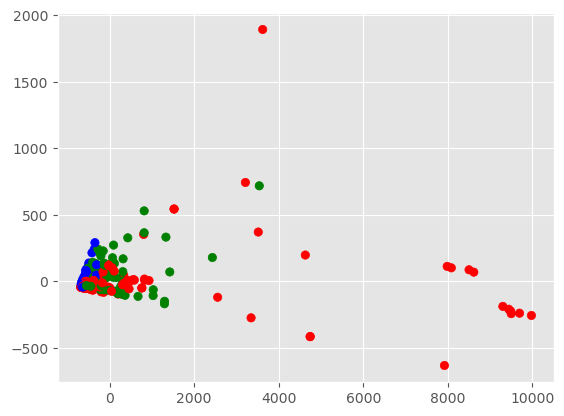

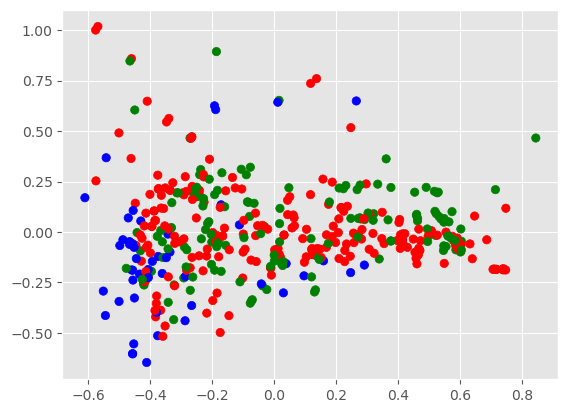

In [38]:
plt.style.use('ggplot')
X = meta_df.loc[:, ~meta_df.columns.isin(['best_algo', *available_classifiers.keys()])]
X.fillna(0, inplace=True)
y = meta_df['best_algo']
print(set(y))
colors = []
color_map = {0 : 'red', 1: 'green', 2: 'blue'}
for i in pd.factorize(y)[0]:
    colors.append(color_map[i])
for x in [X, norm_min_max(X.values)]:
    pca = PCA(n_components=2)
    x_new = pca.fit_transform(x)
    plt.scatter(x_new[:, 0], x_new[:, 1], c=colors)
    plt.show()

In [41]:
def naive_score(ys):
    val_class = ys.mode()[0]
    pred = [val_class] * len(ys)
    print(f"Most popular algo (naive): `{val_class}`")
    return f1_score(ys, pred, average='micro')

xs = norm_min_max(X.values)
ys = y.values
all_scores = dict()
for classifier_name in available_classifiers:
    cls = available_classifiers[classifier_name]()
    cls.fit(xs, ys)
    pred = cls.predict(xs)
    score = f1_score(ys, pred, average='micro')
    all_scores[classifier_name] = score
best = [k for k, v in all_scores.items() if v == max(all_scores.values())][0]
best, scores = [best], all_scores
naive = naive_score(y)
print(f"Best algo on meta-dataset: `{best[0]}`")
print(f"All predicted algos scores: `{scores}`")
print(f'Naive f-score: {naive}')

Most popular algo (naive): `decision_tree`
Best algo on meta-dataset: `decision_tree`
All predicted algos scores: `{'decision_tree': 0.7453703703703705, 'naive_bayes': 0.6550925925925926, 'SVM_poly': 0.6921296296296297}`
Naive f-score: 0.5393518518518519
